In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

In [35]:
import pytesseract
import re

from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Example path on Windows


In [36]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [107]:
DIGITS_LOOKUP = {
    (1, 1, 1, 1, 1, 1, 0): 0,
    (1, 1, 0, 0, 0, 0, 0): 1,
    (1, 0, 1, 1, 0, 1, 1): 2,
    (1, 1, 1, 0, 0, 1, 1): 3,
    (1, 1, 0, 0, 1, 0, 1): 4,
    (0, 1, 1, 0, 1, 1, 1): 5,
    (0, 1, 1, 1, 1, 1, 1): 6,
    (1, 1, 0, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 0, 1, 1, 1): 9,
    (0, 0, 0, 0, 0, 1, 1): '-'
}
H_W_Ratio = 1.9
THRESHOLD = 35
arc_tan_theta = 6.0  
crop_y0 = 215
crop_y1 = 470
crop_x0 = 260
crop_x1 = 890

In [108]:
img1 = cv2.imread('./Images/img1.jpg',0) 
img2 = cv2.imread('./Images/img2.jpg',0) 
img3 = cv2.imread('./Images/img3.jpg',0) 
img4 = cv2.imread('./Images/img4.jpg',0) 
img5 = cv2.imread('./Images/img5.jpg',0) 
img6 = cv2.imread('./Images/img6.jpg',0) 
img7 = cv2.imread('./Images/img7.jpg',0) 
img8 = cv2.imread('./Images/img8.jpg',0) 
img9 = cv2.imread('./Images/img9.jpg',0) 
img10 = cv2.imread('./Images/img10.jpg',0) 
img11 = cv2.imread('./Images/img12.jpg',0) 

fm = cv2.imread('./Images/fm1.jpg',0)

In [109]:
# blurred = fm
blurred = cv2.GaussianBlur(fm, (7, 7), 0)


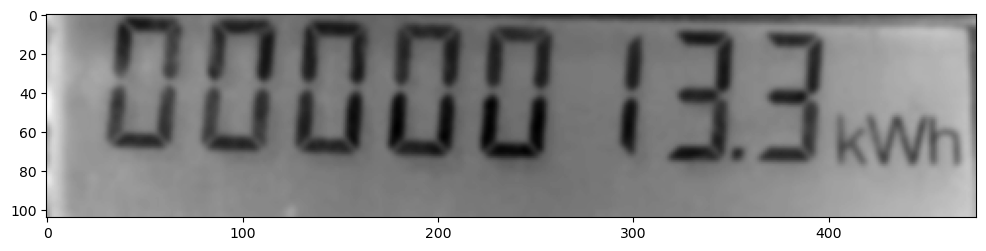

In [110]:
display(blurred)

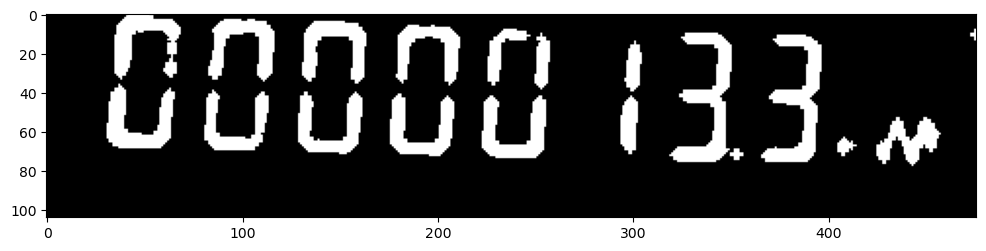

In [111]:
dst = preprocess(blurred, THRESHOLD, show=0)
display(dst)


In [112]:
digits_positions = find_digits_positions(dst)
digits_positions


AssertionError: Failed to find digits's positions

In [78]:

output = blurred
digits = recognize_digits_line_method(digits_positions, output, dst)
print(digits)

['*', '*', '.', '*', '*', '.', '*', '.', '*', '*', '*']


def main():
    args = parser.parse_args()
    blurred, gray_img = load_image(args.image_path, show=args.show_image)
    output = blurred
    dst = preprocess(blurred, THRESHOLD, show=args.show_image)
    digits_positions = find_digits_positions(dst)
    digits = recognize_digits_line_method(digits_positions, output, dst)
    if args.show_image:
        cv2.imshow('output', output)
        cv2.waitKey()
        cv2.destroyAllWindows()
    print(digits)


if __name__ == '__main__':
    main()

In [22]:
def preprocess(img, threshold, show=False, kernel_size=(5, 5)):
     
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(6, 6))
    img = clahe.apply(img)
    
    dst = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 127, threshold)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)

 
    return dst

def helper_extract(one_d_array, threshold=20):
    res = []
    flag = 0
    temp = 0
    for i in range(len(one_d_array)):
        if one_d_array[i] < 12 * 255:
            if flag > threshold:
                start = i - flag
                end = i
                temp = end
                if end - start > 20:
                    res.append((start, end))
            flag = 0
        else:
            flag += 1

    else:
        if flag > threshold:
            start = temp
            end = len(one_d_array)
            if end - start > 50:
                res.append((start, end))
    return res


def find_digits_positions(img, reserved_threshold=20):
    # cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # digits_positions = []
    # for c in cnts[1]:
    #     (x, y, w, h) = cv2.boundingRect(c)
    #     cv2.rectangle(img, (x, y), (x + w, y + h), (128, 0, 0), 2)
    #     cv2.imshow('test', img)
    #     cv2.waitKey(0)
    #     cv2.destroyWindow('test')
    #     if w >= reserved_threshold and h >= reserved_threshold:
    #         digit_cnts.append(c)
    # if digit_cnts:
    #     digit_cnts = contours.sort_contours(digit_cnts)[0]

    digits_positions = []
    img_array = np.sum(img, axis=0)
    horizon_position = helper_extract(img_array, threshold=reserved_threshold)
    img_array = np.sum(img, axis=1)
    vertical_position = helper_extract(img_array, threshold=reserved_threshold * 4)
    # make vertical_position has only one element
    if len(vertical_position) > 1:
        vertical_position = [(vertical_position[0][0], vertical_position[len(vertical_position) - 1][1])]
    for h in horizon_position:
        for v in vertical_position:
            digits_positions.append(list(zip(h, v)))
    assert len(digits_positions) > 0, "Failed to find digits's positions"

    return digits_positions

In [23]:

def recognize_digits_area_method(digits_positions, output_img, input_img):
    digits = []
    for c in digits_positions:
        x0, y0 = c[0]
        x1, y1 = c[1]
        roi = input_img[y0:y1, x0:x1]
        h, w = roi.shape
        suppose_W = max(1, int(h / H_W_Ratio))
        # 对1的情况单独识别
        if w < suppose_W / 2:
            x0 = x0 + w - suppose_W
            w = suppose_W
            roi = input_img[y0:y1, x0:x1]
        width = (max(int(w * 0.15), 1) + max(int(h * 0.15), 1)) // 2
        dhc = int(width * 0.8)
        # print('width :', width)
        # print('dhc :', dhc)

        small_delta = int(h / arc_tan_theta) // 4
        # print('small_delta : ', small_delta)
        segments = [
            # # version 1
            # ((w - width, width // 2), (w, (h - dhc) // 2)),
            # ((w - width - small_delta, (h + dhc) // 2), (w - small_delta, h - width // 2)),
            # ((width // 2, h - width), (w - width // 2, h)),
            # ((0, (h + dhc) // 2), (width, h - width // 2)),
            # ((small_delta, width // 2), (small_delta + width, (h - dhc) // 2)),
            # ((small_delta, 0), (w, width)),
            # ((width, (h - dhc) // 2), (w - width, (h + dhc) // 2))

            # # version 2
            ((w - width - small_delta, width // 2), (w, (h - dhc) // 2)),
            ((w - width - 2 * small_delta, (h + dhc) // 2), (w - small_delta, h - width // 2)),
            ((width - small_delta, h - width), (w - width - small_delta, h)),
            ((0, (h + dhc) // 2), (width, h - width // 2)),
            ((small_delta, width // 2), (small_delta + width, (h - dhc) // 2)),
            ((small_delta, 0), (w + small_delta, width)),
            ((width - small_delta, (h - dhc) // 2), (w - width - small_delta, (h + dhc) // 2))
        ]
        # cv2.rectangle(roi, segments[0][0], segments[0][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[1][0], segments[1][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[2][0], segments[2][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[3][0], segments[3][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[4][0], segments[4][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[5][0], segments[5][1], (128, 0, 0), 2)
        # cv2.rectangle(roi, segments[6][0], segments[6][1], (128, 0, 0), 2)
        # cv2.imshow('i', roi)
        # cv2.waitKey()
        # cv2.destroyWindow('i')
        on = [0] * len(segments)

        for (i, ((xa, ya), (xb, yb))) in enumerate(segments):
            seg_roi = roi[ya:yb, xa:xb]
            # plt.imshow(seg_roi)
            # plt.show()
            total = cv2.countNonZero(seg_roi)
            area = (xb - xa) * (yb - ya) * 0.9
            print(total / float(area))
            if total / float(area) > 0.45:
                on[i] = 1

        # print(on)

        if tuple(on) in DIGITS_LOOKUP.keys():
            digit = DIGITS_LOOKUP[tuple(on)]
        else:
            digit = '*'
        digits.append(digit)
        cv2.rectangle(output_img, (x0, y0), (x1, y1), (0, 128, 0), 2)
        cv2.putText(output_img, str(digit), (x0 - 10, y0 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 128, 0), 2)

    return digits


def recognize_digits_line_method(digits_positions, output_img, input_img):
    digits = []
    for c in digits_positions:
        x0, y0 = c[0]
        x1, y1 = c[1]
        roi = input_img[y0:y1, x0:x1]
        h, w = roi.shape
        suppose_W = max(1, int(h / H_W_Ratio))

        # 消除无关符号干扰
        if x1 - x0 < 25 and cv2.countNonZero(roi) / ((y1 - y0) * (x1 - x0)) < 0.2:
            continue

        # 对1的情况单独识别
        if w < suppose_W / 2:
            x0 = max(x0 + w - suppose_W, 0)
            roi = input_img[y0:y1, x0:x1]
            w = roi.shape[1]

        center_y = h // 2
        quater_y_1 = h // 4
        quater_y_3 = quater_y_1 * 3
        center_x = w // 2
        line_width = 5  # line's width
        width = (max(int(w * 0.15), 1) + max(int(h * 0.15), 1)) // 2
        small_delta = int(h / arc_tan_theta) // 4
        segments = [
            ((w - 2 * width, quater_y_1 - line_width), (w, quater_y_1 + line_width)),
            ((w - 2 * width, quater_y_3 - line_width), (w, quater_y_3 + line_width)),
            ((center_x - line_width - small_delta, h - 2 * width), (center_x - small_delta + line_width, h)),
            ((0, quater_y_3 - line_width), (2 * width, quater_y_3 + line_width)),
            ((0, quater_y_1 - line_width), (2 * width, quater_y_1 + line_width)),
            ((center_x - line_width, 0), (center_x + line_width, 2 * width)),
            ((center_x - line_width, center_y - line_width), (center_x + line_width, center_y + line_width)),
        ]
        on = [0] * len(segments)

        for (i, ((xa, ya), (xb, yb))) in enumerate(segments):
            seg_roi = roi[ya:yb, xa:xb]
            # plt.imshow(seg_roi, 'gray')
            # plt.show()
            total = cv2.countNonZero(seg_roi)
            area = (xb - xa) * (yb - ya) * 0.9
            # print('prob: ', total / float(area))
            if total / float(area) > 0.25:
                on[i] = 1
        # print('encode: ', on)
        if tuple(on) in DIGITS_LOOKUP.keys():
            digit = DIGITS_LOOKUP[tuple(on)]
        else:
            digit = '*'

        digits.append(digit)

        # 小数点的识别
        # print('dot signal: ',cv2.countNonZero(roi[h - int(3 * width / 4):h, w - int(3 * width / 4):w]) / (9 / 16 * width * width))
        if cv2.countNonZero(roi[h - int(3 * width / 4):h, w - int(3 * width / 4):w]) / (9. / 16 * width * width) > 0.65:
            digits.append('.')
            cv2.rectangle(output_img,
                          (x0 + w - int(3 * width / 4), y0 + h - int(3 * width / 4)),
                          (x1, y1), (0, 128, 0), 2)
            cv2.putText(output_img, 'dot',
                        (x0 + w - int(3 * width / 4), y0 + h - int(3 * width / 4) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 128, 0), 2)

        cv2.rectangle(output_img, (x0, y0), (x1, y1), (0, 128, 0), 2)
        cv2.putText(output_img, str(digit), (x0 + 3, y0 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 128, 0), 2)
    return digits